In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [27]:
# read in the files
portfolio = pd.read_csv('data/portfolio.csv')
profile = pd.read_csv('data/clean_profile.csv')
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [28]:
portfolio.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [29]:
profile.head(20)

,user_id,gender,age,id,income
0,1,Male,55.00000,0610b486422d4921ae7d2bf64640c50b,112000.0
1,3,Male,75.00000,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,5,Female,68.00000,e2127556f4f64592b11af22de27a7932,70000.0
3,8,Female,65.00000,389bc3fa690240e798340f5a15918d5c,53000.0
4,12,Female,58.00000,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
5,13,Male,61.00000,aa4862eba776480b8bb9c68455b8c2e1,57000.0
6,14,Female,26.00000,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
7,15,Male,62.00000,31dda685af34476cad5bc968bdb01c53,71000.0
8,16,Female,49.00000,62cf5e10845442329191fc246e7bcea3,52000.0
9,18,Female,57.00000,6445de3b47274c759400cd68131d91b4,42000.0


In [30]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
print(profile.describe())

            user_id           age         income
count  14825.000000  14825.000000   14825.000000
mean    8496.961079     48.949515   65404.991568
std     4896.261043     16.308582   21598.299410
min        1.000000     18.000000   30000.000000
25%     4273.000000     35.000000   49000.000000
50%     8490.000000     52.000000   64000.000000
75%    12733.000000     62.000000   80000.000000
max    16999.000000     77.000000  120000.000000


In [32]:
print(profile['gender'].unique())

['Male' 'Female']


In [33]:
transcript.query('event == "transaction"').head(1)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0


In [34]:
transcript.query('event == "offer received"').head(1)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [35]:
transcript.query('event == "offer viewed"').head(1)

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0


In [36]:
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [37]:
print('Unique event types:')
print(transcript['event'].unique())

print('\nDescriptive stats for time:')
print(transcript.describe())

Unique event types:
['offer received' 'offer viewed' 'transaction' 'offer completed']

Descriptive stats for time:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


In [38]:
# Impute Income
profile['income_na'] = profile['income'].isna().astype(int)
profile['income'] = profile['income'].fillna(profile['income'].mean())

## One Hot Encoding

In [39]:
# channel dummies
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

portfolio.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id,,',",",...,e,i,l,m,o,s,w,bogo,discount,informational
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,...,1,1,1,1,1,1,0,1,0,0
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,...,1,1,1,1,1,1,1,1,0,0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,...,1,1,1,1,1,0,1,0,0,1
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,...,1,1,1,1,1,0,1,1,0,0
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,...,1,1,1,1,0,0,1,0,1,0


In [40]:
# gender type dummies
gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')
profile = pd.concat([profile, gender_dummies], axis=1)

profile.head()

,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,1,Male,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1
1,3,Male,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1
2,5,Female,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
3,8,Female,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
4,12,Female,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


In [41]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [42]:
# event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

#profile.drop(['event'], axis=1, inplace=True)

transcript.head()

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0


### Split Offer and Transaction Data Frames

In [43]:
transcript.dtypes

person             object
event              object
value              object
time                int64
offer_completed     int64
offer_received      int64
offer_viewed        int64
dtype: object

In [44]:
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)

### Merge Data Frames

In [45]:
# Check each header row
transcript.head(1)

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0


In [46]:
portfolio.head(1)

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id,,',",",...,e,i,l,m,o,s,w,bogo,discount,informational
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,...,1,1,1,1,1,1,0,1,0,0


In [47]:
profile.head(1)

,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,1,Male,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1


In [48]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
offers.drop(['id_x', 'id_y'], axis=1, inplace=True)
offers.set_index('offer_id', inplace=True)
offers.head(2)

,person,event,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,income,...,e,i,l,m,o,s,w,bogo,discount,informational
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,3,Male,75.0,100000.0,...,1,1,1,1,1,0,1,1,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,3,Male,75.0,100000.0,...,1,1,1,1,1,0,1,1,0,0


In [49]:
transactions = transactions.merge(profile, left_on='person', right_on='id')
transactions.drop(['event'], axis=1, inplace=True)
transactions.head(2)

,person,time,amount,user_id,gender,age,id,income,income_na,gender_Female,gender_Male
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,41,Male,20.0,02c083884c7d45b39cc68e1314fec56c,30000.0,0,0,1
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,41,Male,20.0,02c083884c7d45b39cc68e1314fec56c,30000.0,0,0,1


### Drop Outliers

In [50]:
transactions.describe()

,time,amount,user_id,age,income,income_na,gender_Female,gender_Male
count,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000,123957.0,123957.000000,123957.000000
mean,381.278201,13.996325,8502.048049,47.658011,61843.510250,0.0,0.601620,0.398380
std,201.829085,31.749420,4893.376236,16.501572,20661.890394,0.0,0.489566,0.489566
min,0.000000,0.050000,1.000000,18.000000,30000.000000,0.0,0.000000,0.000000
25%,210.000000,3.660000,4290.000000,33.000000,46000.000000,0.0,0.000000,0.000000
50%,402.000000,10.800000,8505.000000,50.000000,60000.000000,0.0,1.000000,0.000000
75%,552.000000,19.130000,12716.000000,61.000000,74000.000000,0.0,1.000000,1.000000
max,714.000000,1062.280000,16999.000000,77.000000,120000.000000,0.0,1.000000,1.000000


In [51]:
# is the max age at 77 ok?
#if not create a different cleaned profile set to use

### Repeat Offer Exposure

In [ ]:
# the same offer can be received and viewed multiple times
#do we need this
#offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head()

In [53]:
# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']
offers.head()

,person,event,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,income,...,m,o,s,w,bogo,discount,informational,received_time,viewed_time,completed_time
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,0,1,0,3,Male,75.0,100000.0,...,1,1,0,1,1,0,0,0.5,0.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.5,0,0,1,3,Male,75.0,100000.0,...,1,1,0,1,1,0,0,0.0,6.5,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.5,1,0,0,3,Male,75.0,100000.0,...,1,1,0,1,1,0,0,0.0,0.0,132.5
9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408.5,0,1,0,5,Female,68.0,70000.0,...,1,1,0,1,1,0,0,408.5,0.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420.5,0,0,1,5,Female,68.0,70000.0,...,1,1,0,1,1,0,0,0.0,420.5,0.0


In [54]:
# an offer can be received multiple times by the same person
# we'll use first exposure times, but keep track of the number of exposures

offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sums = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

offers_mins.update(offers_sums)

offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()

offers_grouped.fillna(0, inplace=True)

offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,user_id,gender,age,income,...,m,o,s,w,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,3793,Female,33.0,72000.0,...,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,3793,Female,33.0,72000.0,...,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,3793,Female,33.0,72000.0,...,1,1,1,0,0,0,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,3793,Female,33.0,72000.0,...,1,1,1,1,1,0,0,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,3793,Female,33.0,72000.0,...,1,1,1,1,0,1,0,504.5,540.5,528.5


### Drop Missatributions

In [55]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration'] * 24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis=1)

# dropping misattributions (completion without view, completion before view, or view before receipt)
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

### Regency and Frequency

In [56]:
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)

profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

customers = profile.join(rf)
customers.head()

,user_id,gender,age,income,income_na,gender_Female,gender_Male,frequency,recency,monetary_value
person,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,Male,55.0,112000.0,0,0,1,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,3,Male,75.0,100000.0,0,0,1,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,5,Female,68.0,70000.0,0,1,0,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,8,Female,65.0,53000.0,0,1,0,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,12,Female,58.0,51000.0,0,1,0,3.0,15.0,4.433333


### Conversion Rates

In [57]:
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean() 

# BOGO offers
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# discount offers
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

,user_id,gender,age,income,income_na,gender_Female,gender_Male,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,total_cr
person,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,Male,55.0,112000.0,0,0,1,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,3,Male,75.0,100000.0,0,0,1,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,1.000000
e2127556f4f64592b11af22de27a7932,5,Female,68.0,70000.0,0,1,0,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.666667
389bc3fa690240e798340f5a15918d5c,8,Female,65.0,53000.0,0,1,0,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,12,Female,58.0,51000.0,0,1,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.500000


### Customer Offers

### will redo with Json and Better cleaned profile

## VISUALIZING DATA

In [68]:
# create Instacart color scheme with adobe scan
instacart = ["#5CA43A", "#FF4D00", "#85BD69", "#E7AD75"]
instacart_d = ["#00DDD2", "#8BF3B0", "#B5F7A6","#00C0B0"]
genders = ["#6880f8", "#C668B8"]

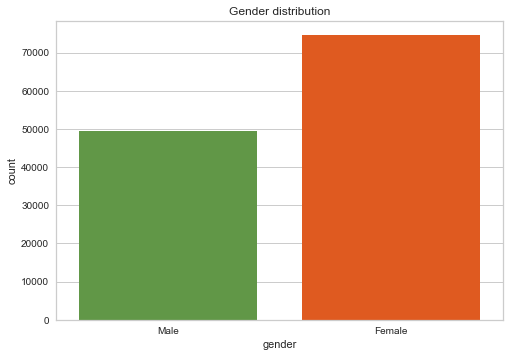

In [69]:
sns.set_palette(sns.color_palette(instacart))

df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

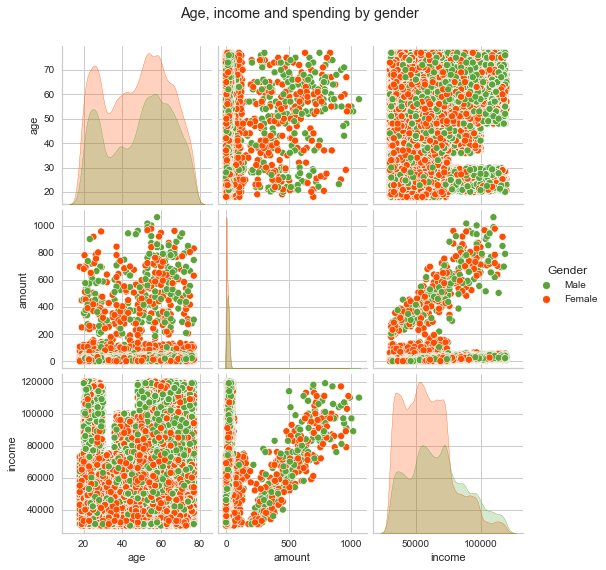

In [72]:
sns.set_palette(sns.color_palette(instacart))

df = transactions[['gender', 'age', 'amount', 'income']].query('gender in ["Female", "Male"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'Male': 'Male', 'Female': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

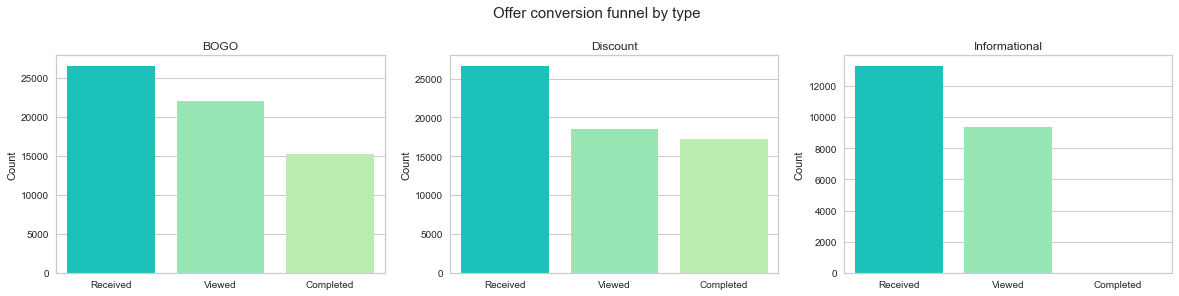

In [73]:
sns.set_palette(sns.color_palette(instacart))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=instacart_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=instacart_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=instacart_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

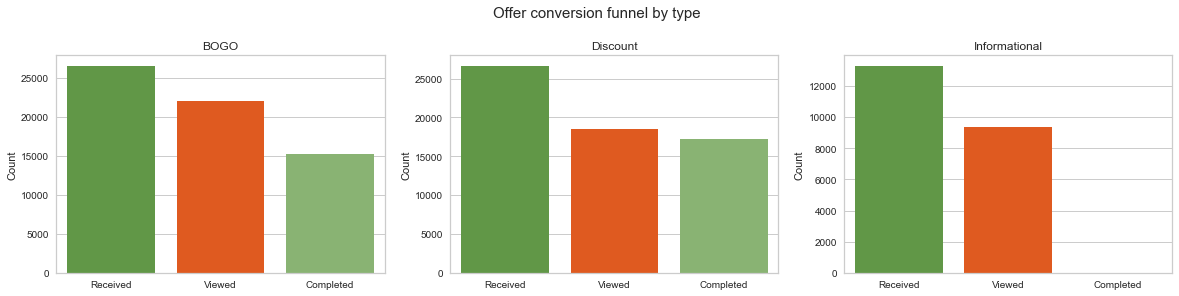

In [81]:
#Try with second pallette 
sns.set_palette(sns.color_palette(instacart))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=instacart, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=instacart, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=instacart, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);